In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv('../data/movies_clean.csv')
test_df = pd.read_csv('../data/test_set.csv')

# Change some fields to the right data type
df['keywords'] = df['keywords'].fillna('')
test_df['recommendations'] = test_df['recommendations'].apply(literal_eval)

# Get index from id
id_list = df['id']
indices = pd.Series(df.index, index=df['id'])

# Calculate tf-idf matrix of keywords
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df=0)
tfidf_matrix = tf.fit_transform(df['keywords'])

# Calculate count matrix of metadata
cnt = CountVectorizer(analyzer='word', ngram_range=(1, 1), min_df=0)
count_matrix = cnt.fit_transform(df['metadata'])

In [2]:
def get_recommendations(movie_id, k=10, alpha=0.55, min_vote_average=5, min_vote_count=1000):
    filter_recommend_df = df[(df['vote_average'] >= min_vote_average) & (df['vote_count'] >= min_vote_count)]
    filter_recommend_idx_list = filter_recommend_df.index

    idx = indices[movie_id]
    cos_sim_list1 = cosine_similarity(tfidf_matrix[idx], tfidf_matrix[filter_recommend_idx_list])[0]
    cos_sim_list2 = cosine_similarity(count_matrix[idx], count_matrix[filter_recommend_idx_list])[0]
    similarity = alpha * cos_sim_list1 +  (1 - alpha) * cos_sim_list2

    similarity = list(zip(filter_recommend_idx_list ,similarity))
    similarity = sorted(similarity, key=lambda x: x[1], reverse=True)

    movie_indices = [i[0] for i in similarity]
    recommended_movies = df.iloc[movie_indices]
    recommended_movies = recommended_movies[1:k+1]

    return list(recommended_movies['id'])

# Evaluation Metric (comparing with themoviedb.org recommendation)
def compare_baseline_similar_percentage(alpha=0.55, min_vote_average=4, min_vote_count=700):
    sum_score = 0
    for row in test_df.itertuples():
        id, test_recommends = row.id, row.recommendations
        recommends_len = len(test_recommends)

        train_recommends = get_recommendations(id, 10, alpha, min_vote_average, min_vote_count)
        match_count = len(set(test_recommends) & set(train_recommends))
        sum_score += match_count / 10
    
    return sum_score / len(test_df)

compare_baseline_similar_percentage(alpha=0.55, min_vote_average=4, min_vote_count=700)

0.1544689119171002

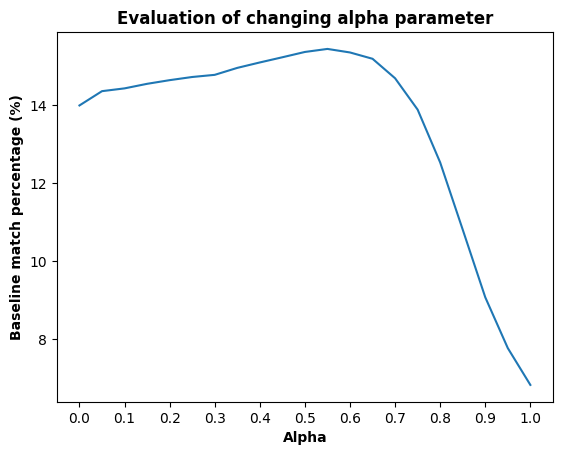

In [17]:
# alpha from 0 -> 1, min vote average thresh = 4, min vote count thresh = 700
alpha_list = [i * 0.05 for i in range(0, 21)]
score_list = [0.13989637305699593, 0.14355569948186653, 0.14426813471502722, 0.14543393782383554, 0.1463730569948199, 0.147182642487048, 0.14773316062176303, 0.1495142487046648, 0.15090673575129687, 0.15223445595855079, 0.15359455958549387, 0.15437176165803282, 0.15346502590673736, 0.1518458549222814, 0.14685880829015674, 0.13882772020725503, 0.12529145077720305, 0.10809585492228002, 0.0907707253886003, 0.07775259067357396, 0.06832901554404044]
score_list = [i * 100 for i in score_list]
plt.plot(alpha_list, score_list)
plt.xlabel('Alpha', fontweight='bold')
plt.ylabel('Baseline match percentage (%)', fontweight='bold')
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.title('Evaluation of changing alpha parameter', fontweight='bold')
plt.show()

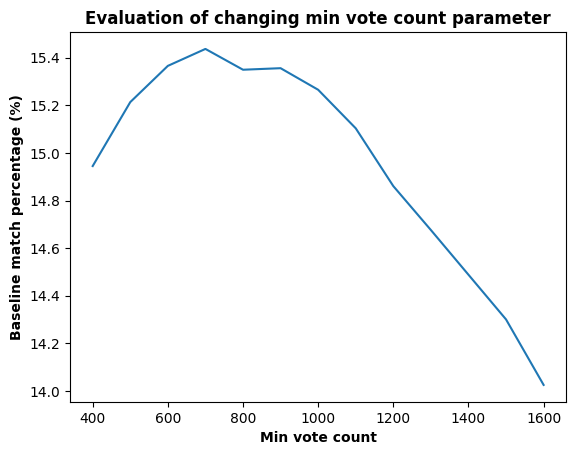

In [18]:
# alpha = 0.55, min vote average thresh = 4, min vote count thresh from 400 -> 1600
min_vote_count_list = range(400, 1700, 100)
score_list = [0.14944948186528653, 0.15213730569948353, 0.15365932642487226, 0.15437176165803282, 0.15349740932642655, 0.15356217616580486, 0.1526554404145095, 0.1510362694300535, 0.1486075129533693, 0.14676165803108948, 0.1448834196891205, 0.14300518134715154, 0.1402525906735764]
score_list = [i * 100 for i in score_list]
plt.plot(min_vote_count_list, score_list)
plt.xlabel('Min vote count', fontweight='bold')
plt.ylabel('Baseline match percentage (%)', fontweight='bold')
plt.title('Evaluation of changing min vote count parameter', fontweight='bold')
plt.show()

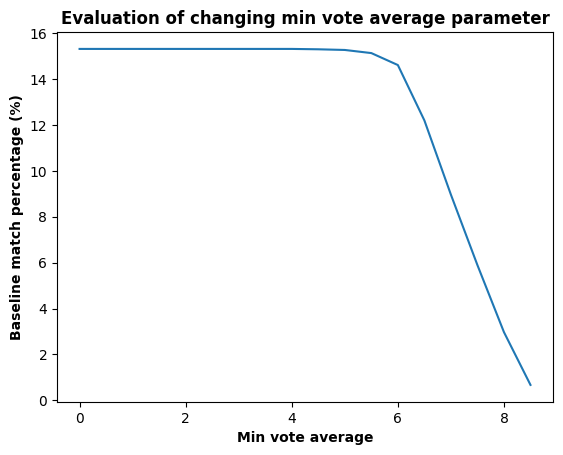

In [19]:
# alpha = 0.55, min vote average thresh from 0 to 8.5, min vote count thresh = 700
min_vote_average_list = [i * 0.5 for i in range(0, 18)]
score_list = [0.15310880829015713, 0.15310880829015713, 0.15310880829015713, 0.15310880829015713, 0.15310880829015713, 0.15310880829015713, 0.15310880829015713, 0.15310880829015713, 0.15310880829015716, 0.15294689119171156, 0.1526554404145095, 0.15129533678756638, 0.14608160621761793, 0.1219559585492238, 0.08960492227979236, 0.05890544041450706, 0.02969559585492208, 0.006703367875647676]
score_list = [i * 100 for i in score_list]
plt.plot(min_vote_average_list, score_list)
plt.xlabel('Min vote average', fontweight='bold')
plt.ylabel('Baseline match percentage (%)', fontweight='bold')
plt.title('Evaluation of changing min vote average parameter', fontweight='bold')
plt.show()